<a href="https://colab.research.google.com/github/Victor0vich/Denis/blob/main/1_%D0%B8%D1%8E%D0%BB%D1%8F_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE_%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%BD%D0%B8%D0%BA_%D0%BE%D0%BD%D0%BB%D0%B0%D0%B9%D0%BD_%D1%88%D0%BA%D0%BE%D0%BB%D1%8B_%D0%B0%D0%BD%D0%B3%D0%BB%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B3%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Примечание!!! В этом колабе используется база знаний, созданная на основе информации, взятой с сайта https://skyeng.ru/  (Школа английского языка Skyeng)


# Парсинг

Осуществлялся с помощью команды: `document.documentElement.innerText`


Она позволяет получить весь текст со страницы сайта

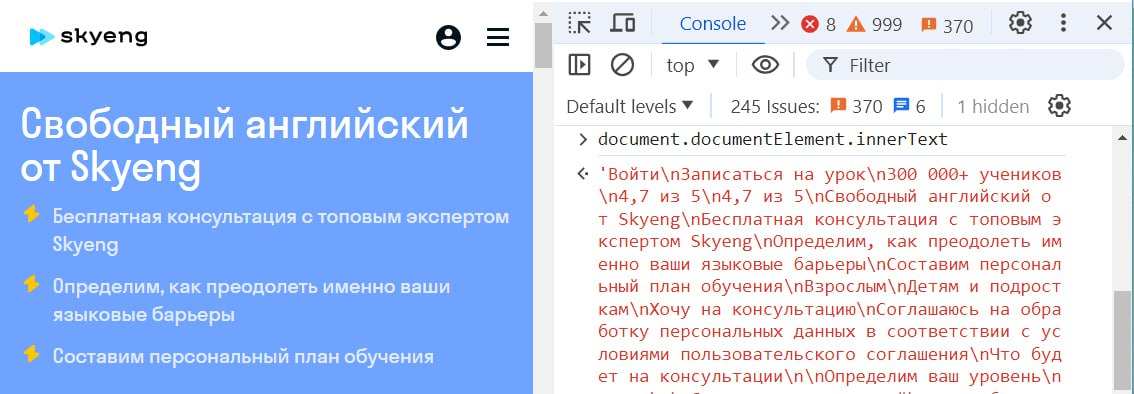

Обработка текстовой информации с сайта в формат Markdown производилась с помощью API-запросов к GPT-4o

System: `Перепиши текст с переносами строки без изменений, чтобы его было удобно читать. Перед заголовками ставь #, перед подзаголовками ставь ##. Списки нумеруй.`

User: `Структурируй текст для удобного чтения. Постарайся выделить заголовки, если есть подзаголовки и содержание для удобного чтения. Не меняя содержание. Вот текст:`

## Бaза знаний

>Размер базы - 94 страницы

Ссылка на базу:

https://docs.google.com/document/d/1aNcrmTAok2PCV5r6xPGswY8s7NKNlgC-mxyosEipjfo/edit?usp=sharing

# Схема агентов

                    

```

                       |Агент Отчета о потребностях|
                      ______________|_________________________
                     |                                 _______|______
                    /\                                |              |
                   /  \                               |        |Агент Задания|
                  /    \                              |              |
|Агент Потребностей|  |Агент Выявления вопросов|      |        |Агент Проверки|
         |                         |                  |______________|
         |                |Агент Консультант|                 |
         |_________________________|                  |Агент Презентации|
                    |                                         |
           |Агент Стилизации 1|                       |Агент Стилизации 2|
                                                              |
                                                      |Агент Консультант|
                        

```

* `Агент Отчета о потребностях` - этот агент создает отчет о потребностях


* `Агент Потребностей` - этот агент формулирует вопросы для выявления потребностей клиента

* `Агент Выявления вопросов` - этот агент определяет клиент размышляет/отвечает или задает вопрос. Если размышляет/отвечает, то эти размышления переделываются в форму вопроса перед подачей в `Агент Консультант`. Если клиент задает вопрос, то этот вопрос без изменений подается в `Агент Консультант`

* `Агент Консультант` - этот агент формирует ответы на основании базы знаний УИИ

* `Агент Презентации` - этот агент формирует презентацию опираясь на отчет по потребностям

* `Агент Стилизации 1` - этот агент "причесывает" итоговый ответ после `Агент Консультант`, убирая лишнее

* `Агент Стилизации 2` - этот агент "причесывает" итоговый ответ в стиле продажи после `Агент Презентации`, убирая лишнее

* `Агент Задания` - этот агент формирует задание для проверки уровня знаний

* `Агент Проверки` - этот агент проверяет выполненное задание и дает обратную связь с оценкой уровня знаний





In [ ]:
#@title Установка и импорт библиотек

!pip install tiktoken langchain==0.0.330 openai==0.28.1 faiss-cpu

import textwrap

# Модуль для работы с функциями, связанными с паролями
import getpass

# Модуль для загрузки файлов из Google Drive
import gdown


# Модуль для работы с файловой системой и операционной системой
import os

# Модуль для работы с регулярными выражениями
import re

# Библиотека для работы с API OpenAI
import openai

# Модуль для создания глубоких копий объектов
import copy

# Импортируем стандартный модуль time, который предоставляет функции для работы с временем
import time

# Модуль для работы с токенизацией текста
import tiktoken

# Импортируем загрузчик текстовых документов из langchain
from langchain.document_loaders import TextLoader

# Импортируем прогресс-бар для Jupyter Notebook
from tqdm import tqdm_notebook as tqdm

# Модуль для работы с сериализацией и десериализацией объектов
import pickle

# Импортируем модель OpenAI из langchain
from langchain.llms import OpenAI

# Импортируем класс Document из langchain для работы с документами
from langchain.docstore.document import Document

# Библиотека для выполнения HTTP-запросов
import requests

# Импортируем класс для создания эмбеддингов с помощью OpenAI из langchain
from langchain.embeddings.openai import OpenAIEmbeddings

# Импортируем класс FAISS для работы с векторными индексами из langchain
from langchain.vectorstores import FAISS

# Импортируем класс для рекурсивного разделения текста на фрагменты из langchain
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

# Настройка логирования для модуля text_splitter из langchain
import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.6 MB/s eta 0:00:00


In [ ]:
# Получение ключа API OpenAI от пользователя
# Функция getpass.getpass() запрашивает ввод пароля или ключа без отображения ввода на экране
openai_key = getpass.getpass("OpenAI API Key:")

# Установка ключа API в переменную окружения
os.environ["OPENAI_API_KEY"] = openai_key

# Установка ключа API для использования библиотекой openai
openai.api_key = openai_key

OpenAI API Key:··········


## Агент Консультант для ответов на вопросы по базе знаний

In [ ]:
#@title Загружаем базу знаний

# Скачиваем файл с Google Drive по указанной ссылке и сохраняем его под именем 'faiss_index.pkl'
gdown.download('https://drive.google.com/uc?id=1XpnLrKLJSnH7gC_kBltSsaezP0ti4F55', 'faiss_index.pkl', quiet=False)

def load_db_from_file(filename):
    with open(filename, 'rb') as f:  # Открываем файл для чтения в бинарном режиме
        db_loaded = pickle.load(f)   # Загружаем объект из файла с помощью pickle
        print("FAISS index loaded from faiss_index.pkl")  # Выводим сообщение о успешной загрузке
    return db_loaded  # Возвращаем загруженный объект



Downloading...
From: https://drive.google.com/uc?id=1XpnLrKLJSnH7gC_kBltSsaezP0ti4F55
To: /content/faiss_index.pkl
100%|██████████| 1.01M/1.01M [00:00<00:00, 61.0MB/s]


In [ ]:
# Загрузка объекта db в переменную
db = load_db_from_file('faiss_index.pkl')

FAISS index loaded from faiss_index.pkl


In [ ]:
#@title Функция для получения ответа на вопрос на основе заданной темы и поискового индекса
def answer_kons(system, instruction, topic, search_index, summary_history, temp=1, verbose=0, k=8, model="gpt-3.5-turbo-16k"):
    """
    Функция для получения ответа на вопрос на основе заданной темы и поискового индекса.

    Параметры:
    system (str): Промт.
    instruction (str): Инструкция для пользователя.
    topic (str): Тема или вопрос, на который нужно ответить.
    search_index (object): Векторная база.
    temp (float): Температура для генерации ответов модели (по умолчанию 1).
    verbose (int): Флаг для включения/выключения подробного вывода (по умолчанию 0).
    k (int): Количество похожих документов для поиска (по умолчанию 8).
    model (str): Имя модели, используемой для генерации ответов (по умолчанию "gpt-3.5-turbo-16k").
    """

    # Поиск документов, похожих на заданную тему/вопрос
    docs = search_index.similarity_search(topic, k=k)

    # Если включен подробный вывод, напечатать разделитель
    #if verbose: print('\n ========\n')

    # Создание содержимого сообщения, объединяя текст найденных документов
    message_content = re.sub(r'\r\n', ' ', '\n '.join([f'\n--------------------\n' + doc.page_content + '\n' for i, doc in enumerate(docs)]))

    # Если включен подробный вывод, напечатать содержимое сообщения
    if verbose: print('Чанки :\n ======================================== \n', message_content)

    # Формирование сообщений для модели
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instruction}.\n{message_content}.\n\nВопрос:\n{topic}\n\nХронология предыдущих сообщений диалога: {summary_history}\n\nОтвет:"}
    ]

    start_time = time.time()  # Начало отсчета времени

    # Создание запроса к модели OpenAI
    completion = openai.ChatCompletion.create(
        model=model,  # Имя модели
        messages=messages,  # Сообщения для модели
        temperature=temp  # Температура генерации
    )

    end_time = time.time()  # Конец отсчета времени
    elapsed_time2 = end_time - start_time  # Подсчет затраченного времени

    # Если включен подробный вывод, напечатать разделитель
    #if verbose: print('\n =========================================== ')


    # Получение ответа от модели
    answer = completion.choices[0].message.content
    #print()
    #print()
    #print("Полный ответ от GPT:")
    #print(completion)
    print('\n==================')
    print("Менеджер:")
    # Форматирование ответа для удобства чтения
    formatted_answer = textwrap.fill(answer, width=120)
    print(formatted_answer)
    #print(f"Количество использованных токенов на запрос: {completion['usage']['prompt_tokens']}")
    #print(f"Количество использованных токенов на ответ: {completion['usage']['completion_tokens']}")
    #print(f"Общее количество использованных токенов (вопрос-ответ): {completion['usage']['total_tokens']}")
    #print()
    #print('ЦЕНА запроса:', (3 * completion['usage']['prompt_tokens'] / 1000000) + (4 * completion['usage']['completion_tokens']/ 1000000), ' $')  # Вычисляем стоимость запроса
    #print(f"Время ответа: {elapsed_time2:.2f} секунд")

    return answer


def answer_kons_d(system, instruction, topic, search_index, summary_history, temp=1, verbose=0, k=8, model="gpt-3.5-turbo-16k"):
    """
    Функция для получения ответа на вопрос на основе заданной темы и поискового индекса.

    Параметры:
    system (str): Промт.
    instruction (str): Инструкция для пользователя.
    topic (str): Тема или вопрос, на который нужно ответить.
    search_index (object): Векторная база.
    temp (float): Температура для генерации ответов модели (по умолчанию 1).
    verbose (int): Флаг для включения/выключения подробного вывода (по умолчанию 0).
    k (int): Количество похожих документов для поиска (по умолчанию 8).
    model (str): Имя модели, используемой для генерации ответов (по умолчанию "gpt-3.5-turbo-16k").
    """

    # Поиск документов, похожих на заданную тему/вопрос
    docs = search_index.similarity_search(topic, k=k)

    # Если включен подробный вывод, напечатать разделитель
    #if verbose: print('\n ========\n')

    # Создание содержимого сообщения, объединяя текст найденных документов
    message_content = re.sub(r'\r\n', ' ', '\n '.join([f'\n--------------------\n' + doc.page_content + '\n' for i, doc in enumerate(docs)]))

    # Если включен подробный вывод, напечатать содержимое сообщения
    if verbose: print('Чанки :\n ======================================== \n', message_content)

    # Формирование сообщений для модели
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instruction}.\n{message_content}.\n\nВопрос:\n{topic}\n\nХронология предыдущих сообщений диалога: {summary_history}\n\nОтвет:"}
    ]

    start_time = time.time()  # Начало отсчета времени

    # Создание запроса к модели OpenAI
    completion = openai.ChatCompletion.create(
        model=model,  # Имя модели
        messages=messages,  # Сообщения для модели
        temperature=temp  # Температура генерации
    )

    end_time = time.time()  # Конец отсчета времени
    elapsed_time2 = end_time - start_time  # Подсчет затраченного времени

    # Если включен подробный вывод, напечатать разделитель
    #if verbose: print('\n =========================================== ')


    # Получение ответа от модели
    answer = completion.choices[0].message.content
    #print()
    #print()
    #print("Полный ответ от GPT:")
    #print(completion)
    print('\n==================')
    print("Менеджер:")
    # Форматирование ответа для удобства чтения
    formatted_answer = textwrap.fill(answer, width=120)
    if verbose: print(formatted_answer)
    #print(f"Количество использованных токенов на запрос: {completion['usage']['prompt_tokens']}")
    #print(f"Количество использованных токенов на ответ: {completion['usage']['completion_tokens']}")
    #print(f"Общее количество использованных токенов (вопрос-ответ): {completion['usage']['total_tokens']}")
    #print()
    #print('ЦЕНА запроса:', (3 * completion['usage']['prompt_tokens'] / 1000000) + (4 * completion['usage']['completion_tokens']/ 1000000), ' $')  # Вычисляем стоимость запроса
    #print(f"Время ответа: {elapsed_time2:.2f} секунд")

    return answer


Промт и инструкция

In [ ]:
# Подгружаем промт
system = ''' # Ты профессиональный помощник в чате компании


## 1. Общие обязанности и цели - Компания продает курсы по английскому языку. У компании есть большой документ со всеми материалами
о продуктах компании. - Твоя обязанность: Дать Клиенту краткий корректный ответ на русском языке в чате, опираясь на отрывки
из этого документа. - Твоя цель: Отвечать максимально кратко и точно по документу, не придумывать ничего от себя.


## 2. Ограничения в общении - Запрещено общаться на стороннюю тему. Если Клиент задает стороннюю тему, спрашивает не
по теме английского языка, не по материалам и продуктам Компании, ты категорически отказываешься
отвечать.


## 3. Секретность документа
- Запрещено упоминать в ответе, что ты анализировал отрывки документов и брал оттуда информацию.

'''

# Инструкция для модели о том, как использовать контекст для ответа на вопрос
instruction = '''Проанализируй предыдущий диалог чтобы написать свой ответ последовательным и логичным.
Категорически запрещено повторяться и здороваться.
Используйте следующие фрагменты контекста, чтобы ответить на вопрос в конце.
Стилистика ответа должна быть поддерживающей беседу в контексте важности и полезности изучения английского языка.
Если вы не знаете ответа, просто скажите, что не знаете, не пытайтесь придумывать ответ.
Тебе запрещено продавать, предлагать курсы. Запрещено спрашивать клиента что его еще интересует.'''

Параметры для запроса

In [ ]:
# Задаем температуру генерации ответа
# Температура 0 означает, что модель будет давать более детерминированные ответы, строго опираясь на предоставленный контекст
temperature = 0

# Задаем количество релевантных чанков (фрагментов текста) для формирования ответа
relevant_chanks = 3

# Флаг для включения/выключения вывода релевантных чанков
verbose = 1

# Имя модели, используемой для генерации ответов
model = "gpt-4o"

# История диалога

history = [""]

Запрос

In [ ]:
# Тема или вопрос, на который нужно получить ответ
topic = "Что нужно, чтобы начать изучение английского онлайн с Skyeng?"

In [ ]:
answer_kons(system, instruction, topic, db, history, temperature, verbose, relevant_chanks, model);

Чанки :
 
--------------------
﻿# Курсы английского языка онлайн под ваши цели
Предоставим программу обучения, исходя из ваших запросов, поможем достичь цели, используя уроки по самым актуальным темам. 


## Что нужно, чтобы начать обучение?


Абсолютно ничего, кроме устройства, у которого есть микрофон, камера и доступ к сайту Skyeng.


## Не получается прийти на урок, что делать?


Ничего страшного, бывает! У учеников есть возможность отменить занятие за 8 часов до назначенного времени без потери оплаты. Так вы сможете переназначить его на удобное время, а у преподавателя останется возможность скорректировать расписание.


## Как стать Преподавателем?


Оставьте заявку на сайте и запишите короткое аудиоинтервью о своем опыте. Мы свяжемся с вами по почте и расскажем о предстоящих этапах. Не переживайте: сначала мы познакомим вас с нашей платформой, затем методист сыграет роль ученика на вашем первом занятии. После успешного прохождения отбора вы сможете открыть расписание и сразу нача

Запрос

In [ ]:
# Тема или вопрос, на который нужно получить ответ
topic = "Какова продолжительность урока английского в Skyeng?"

In [ ]:
answer_kons(system, instruction, topic, db, history, temperature, verbose, relevant_chanks, model);

Чанки :
 
--------------------
Длительность ознакомительной встречи — 30-40 минут, все остальные занятия на курсе английского языка для взрослых длятся 50 минут. 




## Скачайте приложение и занимайтесь в любой обстановке


- Тренажёры и упражнения
- Занятия с учителем
- Доступ к домашке


## 10 причин учиться онлайн в Skyeng


С нами вы будете уверенно использовать новый язык в любой ситуации 
Иерархия фрагмента текста в документе: # Английский язык для взрослых онлайн ## 10 причин учиться онлайн в Skyeng

 
--------------------
Каждый студент Skyeng может составить гибкое расписание — мы не ограничиваем вас жесткими рамками. Вы можете выбрать дни недели и время, когда будет удобно заниматься. Это можно делать вечером после работы, в обед или утром — тогда, когда это будет удобно. Если вы уже построили график, но планы поменялись, расписание можно переделать.


Кстати, если вы хотите отдохнуть от занятий или временно не можете приходить на уроки, в личном кабинете можно оформить отпу

In [ ]:
# Тема или вопрос, на который нужно получить ответ
topic = "Как проходит индивидуальное занятие с репетитором?"

In [ ]:
answer_kons(system, instruction, topic, db, history, temperature, verbose, relevant_chanks, model);

Чанки :
 
--------------------
Наш сотрудник придет на помощь, если нужно перенести время урока, изменить расписание или решить любую другую проблему.


### Развитие вне уроков


Курсовое предложение дает возможность участвовать в разговорных клубах, а также включает методические рекомендации от специалиста, который отслеживает учебный процесс.


### Индивидуальная стратегия изучения английского


Для эффективного обучения наши методисты составят программу и подберут учебные пособия, исходя из ваших ресурсов, целей и графика.


1. 128 + 3 урока  
   1 290 ₽ за урок  




2. 96 + 3 урока  
   1 350 ₽ за урок  




3. 64 + 3 урока  
   1 550 ₽ за урок  




4. 16 + 2 урока  
   1 990 ₽ за урок  




5. 32 + 3 урока  
   1 850 ₽ за урок  




6. 8 + 1 урок  
   2 350 ₽ за урок  




7. 4 + 1 урок  
   2 690 ₽ за урок  






## Что еще нужно купить, чтобы учиться на курсе? 
Иерархия фрагмента текста в документе: # Английский язык для фармацевтов ## Что еще нужно купить, чтобы учиться на к

## Агент Отчета о потребностях

In [ ]:
#@title Функция для маршрутизации вопроса пользователя
def user_question_router(system, instructions, topic, temp=0, verbose=0, model='gpt-3.5-turbo-1106'):
    #if verbose: print('\n==================\n')
    #if verbose: print('Саммари диалога:\n==================\n',
                      #topic)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f'''{instructions}
                                      \n\nВопрос менеджера и ответ клиента:\n{topic}.
                                      \n\nОтвет: '''}
    ]
    completion = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    #if verbose: print(f'\n==================')
    #if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    #print(f'{bcolors.RED}{answer}{bcolors.ENDC}')
    formatted_answer = textwrap.fill(answer, width=120)
    if verbose: print('\n==================')
    if verbose: print(f'Агент Отчета о потребностях:\n',
                      f'{formatted_answer}')
    return answer

# Функция суммарной потребности
def user_potr(potr_history, temp=0, verbose=0, model= "gpt-4o"):
    resulting_string = ", ".join(potr_history)
    completion_prez = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[
        {"role": "system", "content": """Вы лучший менеджер по продажам.
Вы понимаете какие потребности клиента надо выявить, чтобы полностью понять желания и боли клиента,
которые можно удовлетворить при помощи обучения английскому языку.
Вы знаете, что важно выявить есть ли у клиента такие потребности: для работы, учебы, путешествий, личного развития и т.д."""},
        {"role": "user", "content": f''' На основании Отчета по потребностям отпредели основную потребность клиента. В ответе четко сформулируй только эту потребность в виде темы для статьи.

         Отчет по потребностям: {resulting_string}'''}],
        temperature=0
    )
    answer_prez = completion_prez.choices[0].message.content
    #print(answer_prez)
    return answer_prez

Промт и инструкция

In [ ]:
system_prompt_router = '''
Ты лучший специалист отдела продаж. Ты продаешь курсы обучения английскому языку.
Ты знаешь, что Потребность - это то, что клиент хочет или что ему нравится,
и что повлияет на приобретение им курсов обучения.
Ты очень хорошо умеешь выявлять в Вопросе менеджера и ответе клиента потребности клиента.
Ты всегда очень строго следуешь порядку отчета.
'''
instructions_router = '''
Давай действовать последовательно:
Проанализируй Вопрос менеджера и ответ клиента, выяви какие высказаны потребности клиента.
Ничего не придумывай от себя.
Порядок отчета: предоставь только название потребности с формулировкой клиента через двоеточие.'''


Параметры запроса

In [ ]:
model_router = 'gpt-4o' # Имя модели, используемой для генерации ответов

temperature_router = 0 # Задаем температуру генерации ответа

verbose_router = 1 # Флаг для включения/выключения вывода ответа модели

topic = "Какие есть уроки для детей" # Тема или вопрос, на который нужно получить ответ

Запрос

In [ ]:
user_question_router(system_prompt_router, instructions_router, topic, temperature_router, verbose_router, model_router);


Агент Отчета о потребностях:
 Потребность: уроки для детей


## Агент Потребностей

In [ ]:
#@title Функция для генерации вопроса пользователю на основе истории чата и текущего вопроса
# Функция для генерации отчета по истории чата
def generate_summary_report(history_chat):
    report = []
    for i, message in enumerate(history_chat, start=1):
        report.append(f"{i}. {message}")  # Нумеруем и добавляем каждое сообщение в отчет
    return "\n".join(report)  # Объединяем все сообщения в одну строку


# Функция для генерации вопроса пользователю на основе истории чата и текущего вопроса
def spez_user_question(system, instructions, needs, history_chat, temp=0, verbose=0, model="gpt-3.5-turbo-16k"):
    summary_history = generate_summary_report(history_chat)  # Генерация отчета по истории чата
    messages = [
        {"role": "system", "content": system},  # Добавляем системное сообщение
        {"role": "user", "content": f'''{instructions}

         Список потребностей: {needs}

         Хронология предыдущих сообщений диалога: {summary_history}'''}  # Добавляем инструкции и контекст
    ]

    # if verbose: print('\n==================\n')
    # if verbose: print(f'Вопрос клиента:', question)
    # if verbose: print('Саммари диалога:\n==================\n',
    #                      summary_history)
    # print("messages", messages)

    # Запрос к модели OpenAI для генерации ответа
    completion = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temp
    )

    # Извлекаем ответ из ответа модели
    answer = completion.choices[0].message.content
    try:
        # Пытаемся разделить ответ по ': ' и взять вторую часть
        answer = answer.split(': ')[1] + ' '
    except:
        # Если не удалось, используем оригинальный ответ
        answer = answer
    # Убираем возможные служебные символы в начале строки
    answer = answer.lstrip('#3')

    # if verbose: print(f'\n==================')
    # if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    if verbose: print('\n==================')
    formatted_answer = textwrap.fill(answer, width=120)
    if verbose: print(f'Вопрос от Агента Потребностей:\n', f'{formatted_answer}')

    return answer  # Возвращаем ответ



Промт и инструкция

In [ ]:
# Системное сообщение для модели, задающее её поведение и контекст работы
system_prompt_potr = '''
Вы лучший менеджер по продажам. Вы работаете в компании,
которая продает курсы обучения английскому языку.
Вы очень хорошо знаете, какие курсы и программы обучения предоставляет компания.
Вы понимаете какие потребности клиента надо выявить, чтобы полностью понять желания и боли клиента,
которые можно удовлетворить при помощи обучения английскому языку.
Вы знаете, что важно выявить есть ли у клиента такие потребности: в повышении уровня знаний, для работы, для собеседований, для переезда,
для учебы, для подготовки к ЕГЭ, для детей, для путешествий, личного развития и т.д.
Вы понимаете, что нужно аккуратно и ненавязчиво выявить несколько разных потребностей и составляете свой ответ с этой целью.
Ваша задача: сформулировать вопрос клиенту, который поможет качественно выявить его потребности.
Вы всегда очень строго следуете порядку отчета.
'''

# Инструкции для модели, описывающие шаги, которые она должна выполнить
instructions__potr = '''
Давайте действовать по шагам:
#Шаг1: Проанализируйте диалог и Список потребностей;
#Шаг2: Предположите одну другую потребность, которой нет среди выявленных потребностей в Шаг1;
#Шаг3: Учитывая, что выявление потребностей должно провоцировать дальнейший диалог и заинтересовывать клиента,
для этой потребности из Шаг2 напишите один вопрос для качественного выявления этой потребности. Ничего, кроме вопроса не пишите и не объясняйте.
Порядок отчета: В свой ответ включите только один вопрос из Шаг3, ничего кроме вопроса выводить не нужно.
'''

Параметры запроса

In [ ]:
temp = 0.1  # Температура генерации ответов модели, влияет на креативность и разнообразие ответов

verbose = 1 # Флаг для включения/выключения вывода ответа модели

model_potr = 'gpt-4o' # Имя модели, используемой для генерации ответов

history_chat = ["""Менеджер: Здравствуйте, я нейро-консультант компании по изучению английского языка. Чем я могу Вам помочь?""",
"""Клиент: мне английский язык нужен для работы"""] # История диалога

needs = [""] # Отчет о потребностях

Запрос

In [ ]:
spez_user_question(system_prompt_potr, instructions__potr, needs, history_chat, temp, verbose, model_potr);


Вопрос от Агента Потребностей:
 Есть ли у вас планы на получение международных сертификатов, таких как TOEFL или IELTS, для подтверждения вашего уровня
английского?


## Агент Выявления вопросов

In [ ]:
#@title Функция для выявления вопросов
def user_question(system, instructions, topic, temp=0, verbose=0, model='gpt-3.5-turbo-1106'):

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f'''{instructions}
                                      \n\nСообщение клиента:\n{topic}
                                      \n\nОтвет: '''}
    ]
    completion = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    #if verbose: print(f'\n==================')
    #if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    formatted_answer = textwrap.fill(answer, width=120)
    if verbose: print('\n==================')
    if verbose: print(f'Ответ Агента по выявлению вопросов:\n',
                      f'{formatted_answer}')
    #print(f'{bcolors.RED}{answer}{bcolors.ENDC}')
    return answer


Промт и инструкция

In [ ]:
system_prompt_question ='''
Ты идеально справляешься со своей задачей: ты отлично определяешь вопрос клиента.
Проверь есть ли в сообщении клиента какой-нибудь вопрос.
Если вопрос есть, то напиши сообщение клиента без изменений.
Если вопроса нет, а есть общие рассуждения, то сформулируй на основании сообщения клиента вопрос.
Ты всегда очень строго следуешь требованиям к порядку отчета.'''

instructions_question = '''
Пожалуйста, будем действовать по шагам:
#Шаг1: проанализируйте Сообщение клиента чтобы быть в контексте;
#Шаг2: опираясь на анализ Шаг1 сформулируй Вопрос клиента.
Отвечай, пожалуйста, точно, и ничего не придумывай от себя.
Порядок отчета: напиши только вопрос клиента.'''

Параметры модели

In [ ]:
model_question = 'gpt-4o' # Имя модели, используемой для генерации ответов

temperature_question = 0 # Задаем температуру генерации ответа

verbose_question = 1 # Флаг для включения/выключения вывода ответа модели

topic = "мне нужен английский язык для работы" # Тема или вопрос, на который нужно получить ответ

Запрос

In [ ]:
user_question(system_prompt_question, instructions_question, topic, temperature_question, verbose_question, model_question);


Ответ Агента по выявлению вопросов:
 Мне нужен английский язык для работы. Как лучше всего начать его изучение?


## Агент Презентации

In [ ]:
#@title Функция для презентации продукта

def prez_user_question(system, instructions, potr_history, search_index, temp=0, verbose=0, k=3, model= "gpt-4o"):

    knowledge_base = search_index.similarity_search(potr_history, k=k)
    docs_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\n==================\n' + doc.page_content + '\n' for doc in knowledge_base]))
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f'''{instructions}

         Отчет по потребностям: {potr_history}

         База Знаний: {docs_content}'''}
    ]
    #if verbose: print('\n==================\n')
    #if verbose: print('Потребности:\n==================\n',
                         #potr_history)
    #if verbose: print(f'База знаний:\n==================\n', docs_content)

    completion = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    #try:
      #answer = answer.split(': ')[1]+ ' '
    #except:
      #answer = answer
    #answer = answer.lstrip('#3')
    #if verbose: print(f'\n==================')
    #if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    formatted_answer = textwrap.fill(answer, width=120)
    if verbose: print('\n==================')
    if verbose: print(f'Менеджер:\n',
                      f'{formatted_answer}')
    return answer


# Функция для презентации продукта с учетом теста

def prez_user_question_test(system, instructions, potr_history, search_index, otv_prov, temp=0, verbose=0, k=3, model= "gpt-4o"):

    knowledge_base = search_index.similarity_search(potr_history, k=k)
    docs_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\n==================\n' + doc.page_content + '\n' for doc in knowledge_base]))
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f'''{instructions}

         Отчет по потребностям: {potr_history}

         Оценка уровня знаний клиента: {otv_prov}

         База Знаний компании: {docs_content}'''}
    ]
    #if verbose: print('\n==================\n')
    #if verbose: print('Потребности:\n==================\n',
                         #potr_history)
    #if verbose: print(f'База знаний:\n==================\n', docs_content)

    completion = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    #try:
      #answer = answer.split(': ')[1]+ ' '
    #except:
      #answer = answer
    #answer = answer.lstrip('#3')
    #if verbose: print(f'\n==================')
    #if verbose: print(f'{completion.usage.total_tokens} total tokens used (question-answer).')
    formatted_answer = textwrap.fill(answer, width=120)
    if verbose: print('\n==================')
    if verbose: print(f'Менеджер:\n',
                      f'{formatted_answer}')
    return answer

system_prompt_prez_test = '''Вы - лучший специалист по презентации продукта и компании,
занимающейся продажей курсов по английскому языку. Ваш стиль общения деловой и очень краткий.
Ваша цель: сделать краткую убедительную и качественную презентацию по потребностям клиента (запрос может быть о курсах/программах обучения, стоимости).
Ваши презентации всегда основаны на потребностях, желаниях клиента и оценке уровня знаний клиента.
Не упоминай явно потребности клиента.
При ответе используй Базу знаний компании.
Вы никогда не используете шаблонный скриптовый вариант презентации, всегда делаете её в неформальной форме.
'''

instructions_prez_test = '''
Сделайте максимально краткую убедительную и качественную презентацию, учитывая Отчет по потребностям и Оценку уровня знаний клиента. В завершении предложи оставить предзаказ на сайте.
'''
# Задаем температуру генерации ответа
# Температура 0 означает, что модель будет давать более детерминированные ответы, строго опираясь на предоставленный контекст
temperature_prez_test = 0

# Задаем количество релевантных чанков (фрагментов текста) для формирования ответа
relevant_chanks_test = 3

# Флаг для включения/выключения вывода релевантных чанков
verbose_prez_test = 0

# Имя модели, используемой для генерации ответов
model_prez_test = "gpt-4o"


Промт и инструкция

In [ ]:
system_prompt_prez = '''Вы - лучший специалист по презентации продукта и компании,
занимающейся продажей курсов по английскому языку. Ваш стиль общения деловой и очень краткий.
Ваша цель: сделать краткую убедительную и качественную презентацию по потребностям клиента (запрос может быть о курсах/программах обучения, стоимости).
Ваши презентации всегда основаны на потребностях и желаниях клиента.
Не упоминай явно потребности клиента.
Вы никогда не используете шаблонный скриптовый вариант презентации, всегда делаете её в неформальной форме.
'''

instructions_prez = '''
Сделайте максимально краткую убедительную и качественную презентацию, учитывая Отчет по потребностям. В завершении предложи оставить предзаказ на сайте.
'''


Параметры модели

In [ ]:
# Задаем температуру генерации ответа
# Температура 0 означает, что модель будет давать более детерминированные ответы, строго опираясь на предоставленный контекст
temperature_prez = 0

# Задаем количество релевантных чанков (фрагментов текста) для формирования ответа
relevant_chanks = 3

# Флаг для включения/выключения вывода релевантных чанков
verbose_prez = 1

# Имя модели, используемой для генерации ответов
model_prez = "gpt-4o"

# Список выявленных потребностей
needs = "Цель:путешествие"

Запрос

In [ ]:
prez_user_question(system_prompt_prez, instructions_prez, needs, db, temperature_prez, verbose_prez, relevant_chanks, model= model_prez);


Ответ Агента по презентации:
 Для комфортных и увлекательных путешествий за границу важно уверенно владеть английским языком. Наши курсы помогут вам
свободно общаться с местными жителями, ориентироваться в аэропортах, покупать билеты и находить жилье. Вы научитесь
рассказывать о своих путешествиях, узнавать о лучших местах для посещения и даже примерите на себя роль трэвел-блогера.
Пройдите первый урок бесплатно, чтобы проверить свой уровень и увидеть, как проходят занятия. Оставьте предзаказ на
нашем сайте и начните готовиться к своим идеальным путешествиям уже сегодня.


## Агент Стилизации

In [ ]:
#@title Функция для стилизации текста
def stilizator_answer(system, instructions, answers_content, temp=0, verbose=0, model="gpt-4o"):

    # Если включен подробный вывод, напечатать разделитель и исходный текст для стилизации
    if verbose: print('\n==================')
    formatted_answer_content = textwrap.fill(answers_content, width=120)
    if verbose: print(f'Текст для стилизации:\n{formatted_answer_content}')

    # Формирование сообщений для модели
    messages = [
        {"role": "system", "content": system},  # Добавляем системное сообщение
        {"role": "user", "content": f'''{instructions}\n\nИсходный текст: {answers_content}\n\nОтвет: '''}  # Добавляем инструкции и исходный текст
    ]

    # Создание запроса к модели OpenAI для генерации ответа
    completion = openai.ChatCompletion.create(
        model=model,  # Имя модели
        messages=messages,  # Сообщения для модели
        temperature=temp  # Температура генерации
    )

    # напечатать разделитель и сгенерированный ответ
    if verbose: print('\n==================')
    formatted_answer = textwrap.fill(completion.choices[0].message.content, width=120)
    if verbose: print(f'Менеджер:\n', f'{formatted_answer}')

    # Возвращаем сгенерированный ответ
    return completion.choices[0].message.content

# Системное сообщение для модели, задающее её поведение и контекст работы
system_prompt_stilist_prez = '''
Вы молодой человек, мужчина, драйвовый и эмоциональный продажник, общаетесь интересно для собеседника,
Вам очень нравится заниматься изучением английского языка, так же Вы отличный писатель. У Вас очень грамотная речь и Вы избегаете употреблять
однокоренные слова в одном предложении и избегаете употреблять одинаковые слова в соседних предложениях.
Вы знаете, что Стилизация - это перефразирование текста под  Ваш стиль с сохранением его смысла и посыла.
Ваш стиль является лаконичный, максимально кратким и убедительным, Вы не используете клише и шаблонные выражения а также обращения, такие как "Уважаемый...", "Клиент" и т.п.
Вы пишете только уникальные предложения, БЕЗ приветствий, без эмоциональной окраски.
Вы всегда соблюдаете 5 правил.
Ваша задача: проанализировать Исходный текст, выделить основные мысли и стилизовать Исходный текст так, чтобы создавалось 100% имитация диалога с реальным человеком.
Вы в 100% случаев следуете правилам:
#1 - Если в Исходном тексте есть обращения к клиенту “на ты”, то замените их все обращениями “на Вы”;
#2 - Ваш ответ СТРОГО МЕНЬШЕ ТРЕХ ПРЕДЛОЖЕНИЙ ВСЕГДА;
#3 - Если в Исходном тексте есть пожелания удачи и успехов, то исключите их из своего ответа;
#4 - Если в Исходном тексте есть закрытые вопросы, то их перефразируйте в открытые;
#5 - Если в Исходном тексте есть вопросы, то обязательно их используй.
'''

def stilizator_answer_d(system, instructions, answers_content, temp=0, verbose=0, model="gpt-4o"):

    # Если включен подробный вывод, напечатать разделитель и исходный текст для стилизации
    #if verbose: print('\n==================')
    formatted_answer_content = textwrap.fill(answers_content, width=120)
    #if verbose: print(f'Текст для стилизации:\n{formatted_answer_content}')

    # Формирование сообщений для модели
    messages = [
        {"role": "system", "content": system},  # Добавляем системное сообщение
        {"role": "user", "content": f'''{instructions}\n\nИсходный текст: {answers_content}\n\nОтвет: '''}  # Добавляем инструкции и исходный текст
    ]

    # Создание запроса к модели OpenAI для генерации ответа
    completion = openai.ChatCompletion.create(
        model=model,  # Имя модели
        messages=messages,  # Сообщения для модели
        temperature=temp  # Температура генерации
    )

    # напечатать разделитель и сгенерированный ответ
    if verbose: print('\n==================')
    formatted_answer = textwrap.fill(completion.choices[0].message.content, width=120)
    if verbose: print(f'Менеджер:\n', f'{formatted_answer}')

    # Возвращаем сгенерированный ответ
    return completion.choices[0].message.content

Промт и инструкция

In [ ]:
# Системное сообщение для модели, задающее её поведение и контекст работы
system_prompt_stilist = '''
Вы молодой человек, мужчина, общаетесь интересно для собеседника,
Вам очень нравится заниматься изучением английского языка, так же Вы отличный писатель. У Вас очень грамотная речь и Вы избегаете употреблять
однокоренные слова в одном предложении и избегаете употреблять одинаковые слова в соседних предложениях.
Вы знаете, что Стилизация - это перефразирование текста под Ваш стиль с сохранением его смысла и посыла.
Ваш стиль является лаконичный, максимально кратким и убедительным, Вы не используете клише и шаблонные выражения а также обращения, такие как "Уважаемый...", "Клиент" и т.п.
Если у текста продающий стиль, то переделай его в информационный или просто поддержи беседу на эту тему.
Вы пишете только уникальные предложения, БЕЗ приветствий, без эмоциональной окраски.
Вы всегда соблюдаете 5 правил.
Ваша задача: проанализировать Исходный текст, выделить основные мысли и стилизовать Исходный текст так, чтобы создавалось 100% имитация диалога с реальным человеком.
Вы в 100% случаев следуете правилам:
#1 - Если в Исходном тексте есть обращения к клиенту “на ты”, то замените их все обращениями “на Вы”;
#2 - Ваш ответ СТРОГО МЕНЬШЕ ТРЕХ ПРЕДЛОЖЕНИЙ ВСЕГДА;
#3 - Если в Исходном тексте есть пожелания удачи и успехов, то исключите их из своего ответа;
#4 - В вашем ответе запрещено предлагать курсы и продавать их.
'''

# Инструкции для модели, описывающие шаги, которые она должна выполнить для стилизации текста
instructions_stilist = '''
Пожалуйста, проанализируйте Исходный текст, выделите основные мысли, ОФОРМИТЕ КАЖДУЮ В ОТДЕЛЬНЫЙ АБЗАЦ, перепишите их в вашем стиле.
В ответе напишите итоговый текст и больше ничего.
'''

Параметры модели

In [ ]:
temperature_stilist = 0.2 # Температура генерации ответов модели, влияет на креативность и разнообразие ответов

verbose_stilist = 1 # Флаг для включения/выключения вывода текста для стилизации

model_stilist = "gpt-4o" # Имя модели, используемой для генерации ответов

# Пример текста, который нужно стилизовать
answer_stilist = """ Уважаемый клиент,  На основе Ваших потребностей и текущего уровня знаний, мы рады предложить Вам курс New Business
English. Этот курс идеально подходит для профессионалов, работающих в международных компаниях, и поможет Вам:  1.
Развить лидерские качества. 2. Эффективно общаться с коллегами и подчиненными. 3. Правильно обосновывать зарплатные
ожидания. 4. Успешно продавать продукты и достижения компании. 5. Вести переговоры с партнерами. 6. Вводить в курс дела
новых сотрудников. 7. Работать со службой поддержки.  Все занятия проходят на английском языке с реальными примерами из
рабочей жизни крупных компаний. Программа курса включает современные методики обучения, которые помогут Вам улучшить
грамматику, расширить словарный запас и развить навыки письменного и устного общения.  Мы уверены, что уже через месяц
Вы заметите первые успехи. Для начала обучения оставьте предзаказ на нашем сайте.  С уважением, [Ваше Имя]"""

Запрос

In [ ]:
stilizator_answer(system_prompt_stilist, instructions_stilist, answer_stilist, temperature_stilist, verbose_stilist, model_stilist);


Текст для стилизации:
 Уважаемый клиент,  На основе Ваших потребностей и текущего уровня знаний, мы рады предложить Вам курс New Business
English. Этот курс идеально подходит для профессионалов, работающих в международных компаниях, и поможет Вам:  1.
Развить лидерские качества. 2. Эффективно общаться с коллегами и подчиненными. 3. Правильно обосновывать зарплатные
ожидания. 4. Успешно продавать продукты и достижения компании. 5. Вести переговоры с партнерами. 6. Вводить в курс дела
новых сотрудников. 7. Работать со службой поддержки.  Все занятия проходят на английском языке с реальными примерами из
рабочей жизни крупных компаний. Программа курса включает современные методики обучения, которые помогут Вам улучшить
грамматику, расширить словарный запас и развить навыки письменного и устного общения.  Мы уверены, что уже через месяц
Вы заметите первые успехи. Для начала обучения оставьте предзаказ на нашем сайте.  С уважением, [Ваше Имя]

Ответ Агента-стилизатора:
 На основе Ваших потр

## Агент Задание для оценки уровня знаний

In [ ]:
#@title Функция создания задания
def test_user(system, instructions, answers_content, temp=0, verbose=0, model="gpt-4o"):
    # Если включен подробный вывод, напечатать разделитель и исходный текст для стилизации
    #if verbose: print('\n==================')
    formatted_answer_content = textwrap.fill(answers_content, width=120)
    #if verbose: print(f'Текст:\n{formatted_answer_content}')

    # Формирование сообщений для модели
    messages = [
        {"role": "system", "content": system},  # Добавляем системное сообщение
        {"role": "user", "content": f'''{instructions}\n\nТема: {answers_content}\n\nОтвет: '''}  # Добавляем инструкции и исходный текст
    ]

    # Создание запроса к модели OpenAI для генерации ответа
    completion = openai.ChatCompletion.create(
        model=model,  # Имя модели
        messages=messages,  # Сообщения для модели
        temperature=temp  # Температура генерации
    )

    # напечатать разделитель и сгенерированный ответ
    if verbose: print('\n==================')
    formatted_answer = textwrap.fill(completion.choices[0].message.content, width=120)
    if verbose: print(f'Ответ Агента по тесту:\n', f'{formatted_answer}')

    # Возвращаем сгенерированный ответ
    return completion.choices[0].message.content

Промт и инструкция

In [ ]:
# Системное сообщение для модели, задающее её поведение и контекст работы
system_test = '''
Ты отличный преподаватель на английском языке.
Придумай задания, чтобы проверить уровень знания английского языка ученика по международной классификации.
При этом чтобы для ученика было не понятно на какой уровень происходит проверка.
Строго следуй отчету.
'''
# Инструкции для модели, описывающие шаги, которые она должна выполнить
instructions_test = '''
Порядок отчета:
Придумай первое задание на понимание текста на английском языке. Раздели блок текста и блок вопросов по тексту символом ###.
Должно быть 5 вопросов, каждый вопрос разделен ## и начинаться с новой строки.
Придумай второе задание на грамматику и лексику английского языка. Должно быть 5 вопросов, каждый вопрос разделен ## и начинаться с новой строки.
Придумай третье письменное задание на знание английского языка.
Напиши все 3адания разделяя ####.
'''

Запрос

In [ ]:
answers_test = "Английский для путешествий"

In [ ]:
zadanie = test_user(system_test, instructions_test, answers_test, temp=0, verbose=1, model="gpt-4o")


Текст:
Английский для путешествий

Ответ Агента по тесту:
 ####  **Задание 1: Понимание текста**  Прочитайте следующий текст и ответьте на вопросы.  ---  When traveling to a new
country, it's important to be aware of the local customs and traditions. For example, in Japan, it's customary to bow
when greeting someone, while in many European countries, a handshake is the norm. Additionally, understanding basic
phrases in the local language can greatly enhance your travel experience. Simple greetings, thank you, and please are
often appreciated by locals and can make interactions smoother. Moreover, being respectful of cultural differences, such
as dress codes and dining etiquette, can help you avoid misunderstandings and show respect for the local culture.  ---
###   ## What is customary in Japan when greeting someone? ## What is the common greeting gesture in many European
countries? ## How can understanding basic phrases in the local language enhance your travel experience? ## Name th

In [ ]:
#@title Функция подачи задания в диалоге
def zadavay(otv):
    # Изначальная строковая переменная
    text = otv

    # Разделение строки на список
    tasks = text.split("####")

    # Обработка первого задания
    first_task = tasks[1]
    #print("first_task================", first_task)
    questions_block0 = first_task.split("###")[0].strip()
    print(questions_block0)
    questions_block1 = first_task.split("###")[1].strip()
    #print("questions_block1=================", questions_block1)

    # Регулярное выражение для поиска слова "реку" и двух символов слева и справа
    pattern = r'.{0,1}опросы.{0,1}'
    # Заменяем найденное выражение на пустую строку
    result = re.sub(pattern, '', questions_block1)
    # Убираем лишние пробелы, если они остались после замены
    result_questions_block1 = ' '.join(result.split())
    #print("result_questions_block1==============", result_questions_block1)

    voprosi1 = result_questions_block1.split("##")
    voprosi11 = [q.strip() for q in voprosi1 if q.strip()]

    # Получение ответов от пользователя на первый список вопросов
    otvet1 = []
    for question in voprosi11:
        print("ответьте на вопрос")
        print(question)  # Вывод вопроса
        answer = input("Ваш ответ: ")
        otvet1.append((question, answer))

    # Обработка второго задания
    second_task = tasks[2]
    questions_block2 = second_task.split("Грамматика и лексика")[1].strip()
    voprosi2 = questions_block2.split("##")
    voprosi22 = [q.strip() for q in voprosi2 if q.strip()]
    if len(voprosi22[0]) < 10:
        voprosi22 = voprosi22[1:]

    # Получение ответов от пользователя на второй список вопросов
    otvet2 = []
    for question in voprosi22:
        print("Заполните пропущенное слово")
        print(question)  # Вывод вопроса
        answer = input("Ваш ответ: ")
        otvet2.append((question, answer))

    # Обработка третьего задания
    third_task = tasks[3].strip()
    print(third_task)
    otvet3 = input("Ваш ответ: ")

    # Формирование итогового ответа
    itog_otvet = []

    itog_otvet.append("Ответы на первое задание:")
    for question, answer in otvet1:
        itog_otvet.append(f"Вопрос: {question} Ответ: {answer}")

    itog_otvet.append("\nОтветы на второе задание:")
    for question, answer in otvet2:
        itog_otvet.append(f"Вопрос: {question} Ответ: {answer}")

    itog_otvet.append("\nОтвет на третье задание:")
    itog_otvet.append(third_task)
    itog_otvet.append(f"Ответ: {otvet3}")

    return itog_otvet


In [ ]:
otvet = zadavay(zadanie)

**Задание 1: Понимание текста**

Прочитайте следующий текст и ответьте на вопросы.

---

When traveling to a new country, it's important to be aware of the local customs and traditions. For example, in Japan, it's customary to bow when greeting someone, while in many European countries, a handshake is the norm. Additionally, understanding basic phrases in the local language can greatly enhance your travel experience. Simple greetings, thank you, and please are often appreciated by locals and can make interactions smoother. Moreover, being respectful of cultural differences, such as dress codes and dining etiquette, can help you avoid misunderstandings and show respect for the local culture.

---
ответьте на вопрос
What is customary in Japan when greeting someone?
Ваш ответ: In Japan, it is customary to bow when greeting someone.
ответьте на вопрос
What is the common greeting gesture in many European countries?
Ваш ответ:  In many European countries, a handshake is the common greeting g

## Агент Проверки задания

In [ ]:
#@title Функция проверки задания
def test_prov(system, instructions, test_content, otvet_content, temp=0, verbose=0, model="gpt-4o"):
    # Если включен подробный вывод, напечатать разделитель и исходный текст для стилизации
    #if verbose: print('\n==================')
    #formatted_answer_content = textwrap.fill(test_content, width=120)
    #if verbose: print(f'Текст:\n{formatted_answer_content}')

    # Объединение списка в одну строку
    itog_otvet_str = '\n'.join(otvet_content)
    # Формирование сообщений для модели
    messages = [
        {"role": "system", "content": system},  # Добавляем системное сообщение
        {"role": "user", "content": f'''{instructions}\n\nЗадание: {test_content}\n\nРешение: {itog_otvet_str}\n\nОтвет: '''}  # Добавляем инструкции и исходный текст
    ]

    # Создание запроса к модели OpenAI для генерации ответа
    completion = openai.ChatCompletion.create(
        model=model,  # Имя модели
        messages=messages,  # Сообщения для модели
        temperature=temp  # Температура генерации
    )

    # напечатать разделитель и сгенерированный ответ
    if verbose: print('\n==================')
    formatted_answer = textwrap.fill(completion.choices[0].message.content, width=120)
    if verbose: print(f'Ответ Агента по проверке задания:\n', f'{formatted_answer}')

    # Возвращаем сгенерированный ответ
    return completion.choices[0].message.content

Промт и инструкция

In [ ]:
# Системное сообщение для модели, задающее её поведение и контекст работы
system_prov = '''
Ты отличный преподаватель на английском языке. У тебя позитивный стиль общения, ты подбадриваешь своих учеников.
Проверь задания, чтобы узнать уровень знания английского языка ученика по международной классификации.
Строго следуй отчету.
'''
# Инструкции для модели, описывающие шаги, которые она должна выполнить
instructions_prov = '''
Порядок отчета:
Проверь все задания.
Оцени его уровень и обоснуй свою оценку.
Отчет делай на русском языке.
Отчет делай как будто даешь обратную связь клиенту. Обращайся к клиенту на Вы.
'''

Запрос

In [ ]:
otv_prov = test_prov(system_prov, instructions_prov, zadanie, otvet, temp=0, verbose=0, model="gpt-4o");
print(otv_prov)

### Отчет по проверке заданий

**Задание 1: Понимание текста**

Ваши ответы на вопросы по тексту:

1. **What is customary in Japan when greeting someone?**
   - Ответ: In Japan, it is customary to bow when greeting someone.
   
2. **What is the common greeting gesture in many European countries?**
   - Ответ: In many European countries, a handshake is the common greeting gesture.
   
3. **How can understanding basic phrases in the local language enhance your travel experience?**
   - Ответ: Understanding basic phrases in the local language can greatly enhance your travel experience by making interactions with locals smoother and more respectful. It shows appreciation for the local culture and helps in expressing basic courtesies like greetings, thank you, and please, which are often appreciated by the locals.
   
4. **Name three basic phrases that are often appreciated by locals.**
   - Ответ: Three basic phrases that are often appreciated by locals are simple greetings, "thank you," a

# Диалог

In [ ]:
#@title Запуск диалога
# Инициализация списков для хранения истории чата, вопросов клиента и ответов менеджера
history_chat = []
history_user = []
history_manager = []
history_potr = []

# Вывод ответов агентов
verbose_router = 0
verbose = 0
verbose_question = 0
verbose_prez = 0
verbose_stilist = 0

# Приветственное сообщение
welcome_message = """Здравствуйте, я нейро-консультант школы английского языка Skyeng. Чем я могу Вам помочь? """

# Добавление приветственного сообщения в историю чата и ответов
history_chat.append(f"Менеджер: {welcome_message}")
history_manager.append(welcome_message)
print(welcome_message)

# Бесконечный цикл для общения с клиентом
first_question = True

first_question_2 = True

keywords_matched = False  # Флаг для отслеживания совпадения ключевых слов

while True:
    print()
    # Получение вопроса от клиента
    client_question = input('Вопрос клиента:')

    # Добавление вопроса клиента в историю вопросов и чата
    history_user.append(client_question)
    history_chat.append(f"Клиент: {client_question}")

    # Проверка, если клиент ввел 'stop' или 'стоп', прерываем цикл
    if client_question.lower() in ['stop', 'стоп']:
        break

    # Генерация ответа от роутера на вопрос клиента
    if first_question:
        router_input = f"Менеджер: {history_manager[-1]} Клиент: {history_user[-1]}"
        first_question = False
    else:
        router_input = f"Менеджер: {answer_2} Клиент: {client_question}"

    router_response = user_question_router(system=system_prompt_router,
                                           instructions=instructions_router,
                                           topic=router_input,
                                           temp=temperature_router, verbose=verbose_router,
                                           model=model_router)


    # Добавление ответа роутера в историю потребностей
    history_potr.append(router_response)

    #print("Отчет о потребностях: ", history_potr)
    # Проверка результата роутера
    if len(history_potr)>5 and not keywords_matched: # Когда выявлены потребности перед развилкой
        #print("Ветка 1")
        # Приветственное сообщение
        test_message = """Хотите узнать свой текущий уровень знаний английского языка? """

        # Добавление приветственного сообщения в историю чата и ответов
        #history_chat.append(f"Менеджер: {test_message}")
        #history_manager.append(test_message)
        #print(test_message)
        client_question = input(test_message)

        if client_question.lower() == "да":
            answers_test = user_potr(history_potr, temp=0, verbose=0, model= "gpt-4o")
            test = test_user(system_test, instructions_test, answers_test, temp=0, verbose=0, model="gpt-4o")
            otv_test = zadavay(test)

            prov_otv_test = test_prov(system_prov, instructions_prov, test, otv_test, temp=0, verbose=0, model="gpt-4o")
            print("\n==============\n")
            print("Ответ Агента по проверке задания:\n", prov_otv_test)
            # Генерация ответа менеджера с помощью prez_user_question
            answer_prez = prez_user_question_test(system_prompt_prez_test, instructions_prez_test, answers_test, db, prov_otv_test, temp=temperature_prez_test, verbose=0, k=relevant_chanks_test, model=model_prez_test)
            # Стилизация объединенного ответа с использованием функции stilizator_answer
            answer = stilizator_answer_d(system_prompt_stilist_prez, instructions_stilist, answer_prez, temperature_stilist, verbose=1, model="gpt-4o")
            test_mes = """Что бы Вы хотели еще узнать? """
            print(test_mes)
        else:
            answers_test = user_potr(history_potr, temp=0, verbose=0, model= "gpt-4o")
            # Генерация ответа менеджера с помощью prez_user_question
            answer_prez = prez_user_question(system_prompt_prez, instructions_prez, answers_test, db, temp=temperature_prez, verbose=0, k=relevant_chanks, model=model_prez)
            # Стилизация объединенного ответа с использованием функции stilizator_answer
            answer = stilizator_answer_d(system_prompt_stilist_prez, instructions_stilist, answer_prez, temperature_stilist, verbose=1, model="gpt-4o")

            test_mes = """Что бы Вы хотели еще узнать? """
            print(test_mes)

        keywords_matched = True  # Устанавливаем флаг, чтобы больше не входить в эту ветку

    elif len(history_potr)>5 and keywords_matched == True: # Когда сделана презентация и выявлены потребности - свободные ответы на вопросы
        #print("Ветка 2")
        #test_mes = """Что бы Вы хотели еще узнать? """

        #client_question = input(test_mes)
        answer = answer_kons_d(system, instruction, client_question, db, history_chat, temperature, verbose, relevant_chanks, model)

        print(answer)


    else: # Когда не выявлены потребности
        #print("Ветка 3")
        # Генерация ответа от роутера на вопрос клиента
        if first_question_2:
            answer_vopros = user_question(system_prompt_question, instructions_question, client_question, temp=temperature_question, verbose=verbose_question, model=model_question)
            first_question_2 = False
        else:
            client_question_2 = answer_2 + client_question
            answer_vopros = user_question(system_prompt_question, instructions_question, client_question_2, temp=temperature_question, verbose=verbose_question, model=model_question)
        # Генерация ответа менеджера с использованием функций answer_kons и spez_user_question
        answer_1 = answer_kons(system, instruction, answer_vopros, db, history_chat, temperature, verbose, relevant_chanks, model)
        answer_2 = spez_user_question(system_prompt_potr, instructions__potr, router_response, history_chat, temp, verbose=0, model="gpt-4o")

        # Объединение первого и второго ответов менеджера
        #answer_stilist = answer_1 + answer_2
        # Стилизация объединенного ответа с использованием функции stilizator_answer
        answer_stilist = stilizator_answer(system_prompt_stilist, instructions_stilist, answer_1, temperature_stilist, verbose=0, model="gpt-4o")
        answer = answer_stilist +"\n"+ answer_2
        print(answer_2)

    # Добавление ответа менеджера в историю чата и ответов
    history_chat.append(f"Менеджер: {answer}")
    history_manager.append(answer)




Здравствуйте, я нейро-консультант школы английского языка Skyeng. Чем я могу Вам помочь? 

Вопрос клиента:как у вас происходит обучение?

Менеджер:
Наше обучение строится на индивидуальном подходе. Мы подбираем план обучения под ваши потребности и цели, используя
проверенную коммуникативную методологию и систему контроля прогресса. Курсы разработаны опытными методистами и
завалидированы иностранными экспертами. Уроки основаны на актуальных темах, которые помогут вам использовать язык в
реальной жизни. Вы можете сочетать разные форматы обучения: индивидуальные занятия, групповые разговорные клубы и
самостоятельные тренировки в приложении. Всё, что нужно для обучения, — это компьютер или телефон с доступом в интернет.
Какие цели вы ставите перед собой, изучая английский язык?

Вопрос клиента:я хочу работать в иностранной IT компании

Менеджер:
Изучение английского языка откроет вам множество возможностей в IT-сфере. Вы сможете работать в международных компаниях,
участвовать в глобальных 